# Modelo m1rms: otimização do rms assumindo A=A(Ur) e eps=eps(Ur)

---



In [1]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Dissertação Caio

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Dissertação Caio


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import brute
from scipy.optimize import lsq_linear
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing

print('number of cores: ', multiprocessing.cpu_count())

from parametros_OM import Xi_y, m_o, Ca_pot, q_hat, C_dv, C_0l, St, c

n_train = 25
n_parts = 10

number of cores:  8


In [8]:
def polynomial(u, *coefficients):
    return sum(coef * u**i for i, coef in enumerate(coefficients[::-1]))

def fit_train_samples(U, A, eps, train_indices, degreeA=4, degreeEps=4):

    coeff_A, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], A[train_indices],
                         p0=[1]*(degreeA+1))

    coeff_eps, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                           U[train_indices], eps[train_indices],
                           p0=[1]*(degreeEps+1))

    A_poly = polynomial(U, *coeff_A)
    Eps_poly = polynomial(U, *coeff_eps)

    return {
        'A_poly': A_poly,
        'Eps_poly': Eps_poly,
        'coefficients_A': coeff_A,
        'coefficients_eps': coeff_eps,
        'A_function': lambda u: polynomial(u, *coeff_A),
        'Eps_function': lambda u: polynomial(u, *coeff_eps)
    }

def train_system(t, X, i, Aeps):

    S = St*U[i]
    Ur = U[i]

    A, eps = Aeps

    y, y_pd, q, q_pd = X  # Desempacotar as variáveis

    if abs(y + y_pd+ q+q_pd) > 1000:
      raise(ValueError("q_pd > 100"))

    b = (1/(2*np.pi**3))*(Ur**2/(m_o+Ca_pot))
    d = 2*np.pi*C_dv*y_pd/Ur
    e = np.sqrt(1+(2*np.pi*y_pd/Ur)**2)

    y_sd = - y - 2*Xi_y*y_pd + b*((q*c - d)*e)
    q_sd = - eps * S * (q**2 - 1) * q_pd - S**2 * q + A * y_sd

    return [y_pd, y_sd, q_pd, q_sd]

def calculate_prediction(Aeps, i, part_idx):
  x0 = [Y_filtered_parts[part_idx][i, 0], Y_pd_filtered_parts[part_idx][i, 0], Q_filtered_parts[part_idx][i, 0], Q_pd_filtered_parts[part_idx][i, 0]]
  y, y_pd, q, q_pd = solve_ivp(train_system, [t[0], t[-1]], y0 = x0, args=(i, Aeps), t_eval=t, dense_output=True).sol(t)

  return y, q

def loss_rms(Aeps, i, y, part_idx):
  try:
    return (np.mean((calculate_prediction(Aeps, i, part_idx)[0]**2)) - np.mean(y**2))**2
  except ValueError:
    # print("high value detected")
    return 1000

def om_system(x, eps, A, Ur):
    q, q_pd, y, y_pd = x
    S = St * Ur
    term1 = (Ur**2 / (2 * np.pi**3 * (m_o + Ca_pot)))
    term2 = (c * q - 2 * np.pi * C_dv * y_pd / Ur) * np.sqrt(1 + (2 * np.pi * y_pd / Ur)**2)
    y_sd = term1 * term2 - 2 * Xi_y * y_pd - y
    q_sd = A * y_sd - eps * S * (q**2 - 1) * q_pd - S**2 * q
    return [q_pd, q_sd, y_pd, y_sd]

def predict(Ur, t, x0, A, eps, method='RK45'):

    sol = solve_ivp(fun=lambda t, x: om_system(x, eps, A, Ur),
                    t_span=[t[0], t[-1]],
                    y0=x0,
                    t_eval=t,
                    method=method,
                    rtol=1e-5,
                    atol=1e-7)
    Y_predicted = sol.y[2]
    Q_predicted = sol.y[0]

    return Y_predicted, Q_predicted

In [4]:
prefix = './dados/dados experimentais/Data2025mstar26number'
prefixU = './dados/dados experimentais/Ur2025mstar26number'

np.random.seed(42)
all_idxs = list(5*np.random.permutation(list(range(38))) + 95)
all_idxs.remove(190)

allY = np.zeros((len(all_idxs), 18000))
allU = np.zeros(len(all_idxs))
all_n = len(all_idxs)

for i, idx in enumerate(all_idxs):
    if idx == 190:
        pass
    else:
      dados = np.loadtxt(prefix + str(idx), delimiter=',')
      dadosU = np.loadtxt(prefixU + str(idx))
      allY[i, :] = dados[:, 1]
      allU[i] = np.mean(dadosU)

proc_data_path = './dados/dados processados/treino/'

U = np.load(proc_data_path + 'U.npy')
T = np.load(proc_data_path + 'T.npy')

Y_filtered_parts = np.load(proc_data_path + 'Y_filtered_parts.npy')
Y_pd_filtered_parts = np.load(proc_data_path + 'Y_pd_filtered_parts.npy')
Y_sd_filtered_parts = np.load(proc_data_path + 'Y_sd_filtered_parts.npy')
Q_filtered_parts = np.load(proc_data_path + 'Q_filtered_parts.npy')
Q_pd_filtered_parts = np.load(proc_data_path + 'Q_pd_filtered_parts.npy')
Q_sd_filtered_parts = np.load(proc_data_path + 'Q_sd_filtered_parts.npy')

Y_filtered = np.concatenate(Y_filtered_parts, axis=1)
Y_pd_filtered = np.concatenate(Y_pd_filtered_parts, axis=1)
Q_filtered = np.concatenate(Q_filtered_parts, axis=1)
Q_pd_filtered = np.concatenate(Q_pd_filtered_parts, axis=1)

t = np.load('./dados/t_part.npy')

In [5]:
A_parts_rms = np.zeros((n_parts, n_train))
eps_parts_rms = np.zeros((n_parts, n_train))
bounds = [(0, 15), (-0.2, 2)]

"""
for part_idx in tqdm(range(n_parts)):

    q_part = Q_filtered_parts[part_idx]
    q_pd_part = Q_pd_filtered_parts[part_idx]
    q_sd_part = Q_sd_filtered_parts[part_idx]
    y_sd_part = Y_sd_filtered_parts[part_idx]
    y_part = Y_filtered_parts[part_idx]

    for i in range(n_train):

        q = q_part[i, :]
        q_pd = q_pd_part[i, :]
        q_sd = q_sd_part[i, :]
        y_sd = y_sd_part[i, :]
        y = y_part[i, :]
        S = St * U[i]

        res_2, fval, _, _ = brute(loss_rms,  bounds, args=(i, y, part_idx), full_output=True, Ns=20, workers=24)
        A_min, eps_min = res_2

        eps_parts_rms[part_idx, i] = eps_min
        A_parts_rms[part_idx, i] = A_min

        print(f"A_rms: {A_parts_rms[part_idx, i]}, eps_rms: {eps_parts_rms[part_idx, i]}")
        print(f"Difference between rms: {fval}")

np.save('./dados/modelos/A_m1rms.npy', A_parts_rms)
np.save('./dados/modelos/eps_m1rms.npy', eps_parts_rms)"""

'\nfor part_idx in tqdm(range(n_parts)):\n\n    q_part = Q_filtered_parts[part_idx]\n    q_pd_part = Q_pd_filtered_parts[part_idx]\n    q_sd_part = Q_sd_filtered_parts[part_idx]\n    y_sd_part = Y_sd_filtered_parts[part_idx]\n    y_part = Y_filtered_parts[part_idx]\n\n    for i in range(n_train):\n\n        q = q_part[i, :]\n        q_pd = q_pd_part[i, :]\n        q_sd = q_sd_part[i, :]\n        y_sd = y_sd_part[i, :]\n        y = y_part[i, :]\n        S = St * U[i]\n\n        res_2, fval, _, _ = brute(loss_rms,  bounds, args=(i, y, part_idx), full_output=True, Ns=20, workers=24)\n        A_min, eps_min = res_2\n\n        eps_parts_rms[part_idx, i] = eps_min\n        A_parts_rms[part_idx, i] = A_min\n\n        print(f"A_rms: {A_parts_rms[part_idx, i]}, eps_rms: {eps_parts_rms[part_idx, i]}")\n        print(f"Difference between rms: {fval}")\n\nnp.save(\'./dados/modelos/A_m1rms.npy\', A_parts_rms)\nnp.save(\'./dados/modelos/eps_m1rms.npy\', eps_parts_rms)'

In [45]:
A_parts = np.load('./dados/modelos/m1rms/A_m1rms.npy')
eps_parts = np.load('./dados/modelos/m1rms/eps_m1rms.npy')

A_parts_2 = np.load('./dados/modelos/m1rms/A_m1rms_2.npy')
eps_parts_2 = np.load('./dados/modelos/m1rms/eps_m1rms_2.npy')

A_parts[5:,:] = A_parts_2[5:,:]
eps_parts[5:,:] = eps_parts_2[5:,:]


In [59]:
A_mean = np.mean(A_parts, axis=0)
eps_mean = np.mean(eps_parts, axis=0)
A_std = np.std(A_parts, axis=0)
eps_std = np.std(eps_parts, axis=0)
results = fit_train_samples(U, A_mean, eps_mean, range(n_train), degreeA=8, degreeEps=8)
A_poly = results['coefficients_A']
eps_poly = results['coefficients_eps']

In [60]:
np.save('./dados/modelos/m1rms/A_m1rms_polycoeffs.npy', A_poly)
np.save('./dados/modelos/m1rms/eps_m1rms_polycoeffs.npy', eps_poly)

In [61]:
U_plot = np.linspace(3.5, 11, 100)
sorted_idxs = np.argsort(U)
A_plot = polynomial(U_plot, *A_poly)
eps_plot = polynomial(U_plot, *eps_poly)

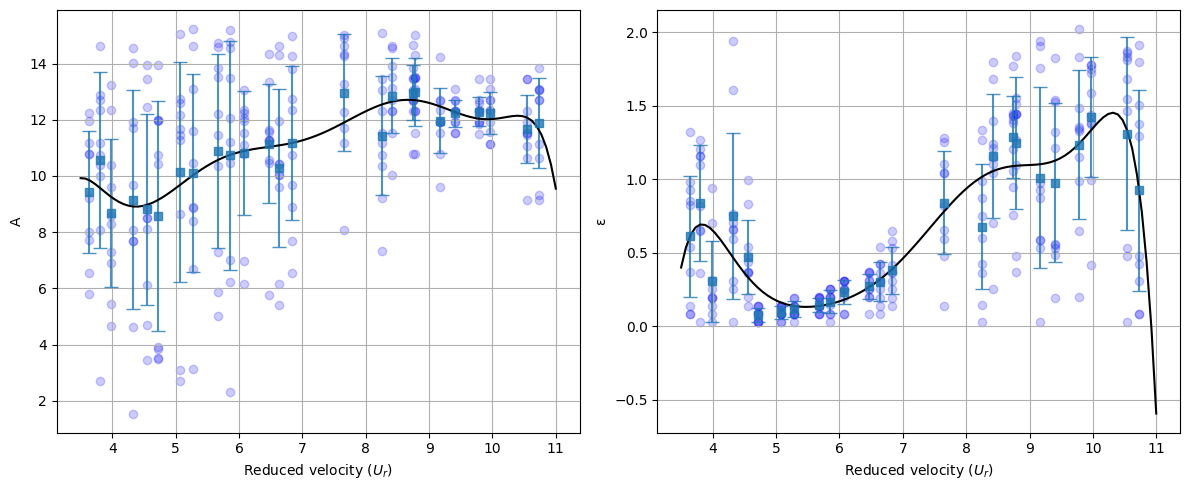

In [62]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for part_idx in range(n_parts):
    plt.scatter(U, A_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], A_mean[sorted_idxs], yerr=A_std[sorted_idxs], fmt='s', alpha=0.8, capsize=5)
plt.plot(U_plot, A_plot, color='black')
plt.xlabel('Reduced velocity ($U_r$)')
plt.ylabel('A')
plt.grid(True)

plt.subplot(1, 2, 2)
for part_idx in range(n_parts):
    plt.scatter(U, eps_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], eps_mean[sorted_idxs], yerr=eps_std[sorted_idxs], fmt='s', alpha = 0.8, capsize=5)
plt.plot(U_plot, eps_plot, color='black')
plt.xlabel('Reduced velocity ($U_r$)')
plt.ylabel('ε')
#plt.ylim([-0.05, .1])
plt.grid(True)

plt.tight_layout()
plt.show()

In [65]:
Ur_values = np.linspace(3.5, 10.8, 60)
t = T[1,:]
Y_predicted = np.zeros((len(Ur_values), len(t)))

for (Ur_idx, Ur) in enumerate(tqdm(Ur_values)):
      A = polynomial(Ur, *A_poly)
      eps = polynomial(Ur, *eps_poly)
      Y_predicted[Ur_idx,:], _ = predict(Ur, t, [0.01,0.0,.5,0.01], A, eps)

rms_predicted = np.array([np.sqrt(np.mean(Y_predicted[i, :]**2)) for i in range(len(Ur_values))])
rms_experimental = np.array([np.sqrt(np.mean(allY[i, :]**2)) for i in range(all_n)])

100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


In [72]:
Y_predicted_mean = np.zeros((len(U), len(t)))
Y_predicted_upper = np.zeros((len(U), len(t)))
Y_predicted_lower = np.zeros((len(U), len(t)))
X0 = [0.01,0.0,.5,0.01]

for (U_idx, u) in enumerate(tqdm(U)):
    try:
      Y_predicted_mean[U_idx,:], _ = predict(u, t, X0, A_mean[U_idx], eps_mean[U_idx],)
    except:
      pass

for (U_idx, u) in enumerate(tqdm(U)):
    try:
      Y_predicted_upper[U_idx,:], _ = predict(u, t, X0, A_mean[U_idx] + A_std[U_idx], eps_mean[U_idx] + eps_std[U_idx])
    except:
      pass

for (U_idx, u) in enumerate(tqdm(U)):
    try:
      Y_predicted_lower[U_idx,:], _ = predict(u, t, X0, A_mean[U_idx] - A_std[U_idx],eps_mean[U_idx] - eps_std[U_idx])
    except:

      pass



100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


In [73]:
rms_predicted_mean = np.array([np.sqrt(np.mean(Y_predicted_mean[i, :]**2)) for i in range(len(U))])
rms_predicted_upper = np.array([np.sqrt(np.mean(Y_predicted_upper[i, :]**2)) for i in range(len(U))])
rms_predicted_lower = np.array([np.sqrt(np.mean(Y_predicted_lower[i, :]**2)) for i in range(len(U))])

rms_predicted_upper_bar = np.abs(rms_predicted_mean - [max(rms_predicted_mean[i], rms_predicted_upper[i], rms_predicted_lower[i]) for i in range(len(U))])
rms_predicted_lower_bar = np.abs(rms_predicted_mean - [min(rms_predicted_mean[i], rms_predicted_upper[i], rms_predicted_lower[i]) for i in range(len(U))])

<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-1651917832.py:9: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('RMS ( ${\overline{y^2}}$ )')


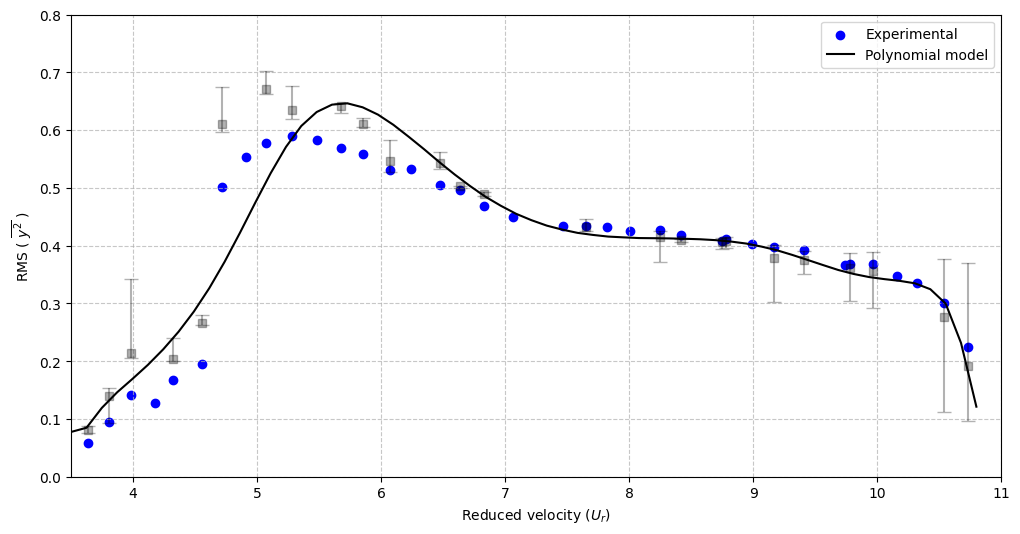

In [75]:
plt.figure(figsize=(12, 6))
plt.scatter(allU, rms_experimental, color='blue', label='Experimental')
plt.plot(Ur_values, rms_predicted, color='black', label='Polynomial model')
plt.errorbar(U[sorted_idxs], rms_predicted_mean[sorted_idxs], yerr=[rms_predicted_lower_bar[sorted_idxs], rms_predicted_upper_bar[sorted_idxs]],
                                                                    fmt='s', alpha=0.3, color='black',capsize=5)
plt.ylim(0, .8)
plt.xlim(3.5, 11)
plt.xlabel('Reduced velocity ($U_r$)')
plt.ylabel('RMS ( ${\overline{y^2}}$ )')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()